In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.reasoner_mod import *
from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *

In [31]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)


In [4]:
def count_el(lista):
    stos = [lista]
    licznik = 0
    while stos:
        aktualna_lista = stos.pop()
        for element in aktualna_lista:
            if isinstance(element, (list, tuple)):
                stos.append(element)
            else:
                licznik += 1
    return licznik

In [5]:
# Filtrowanie data_tr
filtered_data_tr = []
filtered_data_vl = []

for onto, X, y in zip(data_tr[0], data_tr[1], data_tr[2]):
    if count_el(X) <= 3:
        filtered_data_tr.append([onto, X, y])
    else:
        filtered_data_vl.append([onto, X, y])

for onto, X, y in zip(data_vl[0], data_vl[1], data_vl[2]):
    if count_el(X) >= 4:
        filtered_data_vl.append([onto, X, y])
    else:
        filtered_data_tr.append([onto, X, y])


# Przekształcenie z powrotem do oryginalnego formatu
new_data_tr = [[], [], []]
for item in filtered_data_tr:
    new_data_tr[0].append(item[0])
    new_data_tr[1].append(item[1])
    new_data_tr[2].append(item[2])

new_data_vl = [[], [], []]
for item in filtered_data_vl:
    new_data_vl[0].append(item[0])
    new_data_vl[1].append(item[1])
    new_data_vl[2].append(item[2])


# Przypisanie przefiltrowanych danych z powrotem do data_tr
data_tr = new_data_tr
data_vl = new_data_vl

print(f"Liczba elementów w train po filtrowaniu: {len(data_tr[0])}")
print(f"Liczba elementów w val po filtrowaniu: {len(data_vl[0])}")

Liczba elementów w train po filtrowaniu: 49841
Liczba elementów w val po filtrowaniu: 30159


In [32]:
np.mean(data_tr[2])

0.217546875

In [6]:
emb_size = 10
hidden_size = 16
epoch_count = 10
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')
train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count,
                         lr_encoder=0.0001, lr_reasoner=0.00005,
                          batch_size=batch_size, identities_weight=0.02, identitity_weight_decay=0.95)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
train epoch 00/10 | batch 1559/1558 | loss 0.9669 | val loss 0.7733 | acc 0.2058 | f1 0.3413 | prec 0.2058 | recall 1.0000 | roc auc 0.5136 | pr auc 0.2418 | elapsed 27.58s
train epoch 01/10 | batch 1559/1558 | loss 0.8548 | val loss 0.6095 | acc 0.7194 | f1 0.2140 | prec 0.2525 | recall 0.1856 | roc auc 0.5107 | pr auc 0.2781 | elapsed 49.71s
train epoch 02/10 | batch 1559/1558 | loss 0.7006 | val loss 0.5252 | acc 0.8192 | f1 0.3111 | prec 0.7207 | recall 0.1984 | roc auc 0.6194 | pr auc 0.4309 | elapsed 50.13s
train epoch 03/10 | batch 1559/1558 | loss 0.5827 | val loss 0.4669 | acc 0.8250 | f1 0.4336 | prec 0.6493 | recall 0.3255 | roc auc 0.7231 | pr auc 0.5389 | elapsed 48.40s
train epoch 04/10 | batch 1559/1558 | loss 0.4944 | val loss 0.4390 | acc 0.8269 | f1 0.5044 | prec 0.6136 | recall 0.4281 | roc auc 0.7623 | pr auc 0.5833 | elapsed 48.78s
train epoch 05/10 | batch 1559/1558 | loss 0.4259 |

In [25]:
# Filtrowanie data_tr
filtered_data_te = []
for onto, X, y in zip(data_te[0], data_te[1], data_te[2]):
    if count_el(X) >= 4:
        filtered_data_te.append([onto, X, y])

# Przekształcenie z powrotem do oryginalnego formatu
new_data_te = [[], [], []]
for item in filtered_data_te:
    new_data_te[0].append(item[0])
    new_data_te[1].append(item[1])
    new_data_te[2].append(item[2])

# Przypisanie przefiltrowanych danych z powrotem do data_tr
data_te_te = new_data_te

print(f"Liczba elementów po filtrowaniu: {len(data_te_te[0])}")

Liczba elementów po filtrowaniu: 15217


In [26]:
# Filtrowanie data_tr
filtered_data_te = []
for onto, X, y in zip(data_te[0], data_te[1], data_te[2]):
    if count_el(X) < 4:
        filtered_data_te.append([onto, X, y])

# Przekształcenie z powrotem do oryginalnego formatu
new_data_te = [[], [], []]
for item in filtered_data_te:
    new_data_te[0].append(item[0])
    new_data_te[1].append(item[1])
    new_data_te[2].append(item[2])

# Przypisanie przefiltrowanych danych z powrotem do data_tr
data_te_tr = new_data_te

print(f"Liczba elementów po filtrowaniu: {len(data_te_tr[0])}")

Liczba elementów po filtrowaniu: 24783


In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_test = pd.DataFrame({
    'ontology_id': data_te_te[0],
    'X': data_te_te[1],
    'y': data_te_te[2]
})

def stratified_group_split(data, group_col, stratify_col, test_size=0.5, val_size=0.5):
    groups = data[group_col].unique()
    val_idx, test_idx = [], []

    for group in groups:
        group_data = data[data[group_col] == group]
        val_data, test_data = train_test_split(group_data, test_size=test_size, stratify=group_data[stratify_col], random_state=seed)

        val_idx.extend(val_data.index)
        test_idx.extend(test_data.index)

    return data.loc[val_idx], data.loc[test_idx]

val_data, test_data = stratified_group_split(data_test, 'ontology_id', 'y', test_size=0.5, val_size=0.5)


X_te_val = val_data['X'].tolist()
y_te_val = val_data['y'].tolist()
idx_te_val = val_data['ontology_id'].tolist()

data_te_vl = [idx_te_val, X_te_val, y_te_val] 

X_te_te =  test_data['X'].tolist()
y_te_te = test_data['y'].tolist()
idx_te_te = test_data['ontology_id'].tolist()


In [10]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train_mod(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 776/775 | loss 0.7609 | val loss 0.8330 | acc 0.7030 | f1 0.4371 | prec 0.3525 | recall 0.5751 | roc auc 0.7009 | pr auc 0.5028 | elapsed 7.37s
train epoch 01/10 | batch 776/775 | loss 0.6815 | val loss 0.7295 | acc 0.7285 | f1 0.4627 | prec 0.3835 | recall 0.5830 | roc auc 0.7318 | pr auc 0.5365 | elapsed 11.33s
train epoch 02/10 | batch 776/775 | loss 0.5248 | val loss 0.6519 | acc 0.7481 | f1 0.4885 | prec 0.4120 | recall 0.6000 | roc auc 0.7598 | pr auc 0.5710 | elapsed 12.72s
train epoch 03/10 | batch 776/775 | loss 0.4101 | val loss 0.5941 | acc 0.7662 | f1 0.5195 | prec 0.4418 | recall 0.6302 | roc auc 0.7833 | pr auc 0.6031 | elapsed 13.42s
train epoch 04/10 | batch 776/775 | loss 0.3284 | val loss 0.5510 | acc 0.7798 | f1 0.5417 | prec 0.4648 | recall 0.6492 | roc auc 0.8027 | pr auc 0.6327 | elapsed 12.72s
train epoch 05/10 | batch 776/775 | loss 0.2714 | val loss 0.5185 | acc 0.7921 | f1 0.5634 | prec 0.4866 | recall 0.6689 | roc au

In [11]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te_te, y_te_te, idx_te_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240712T191056


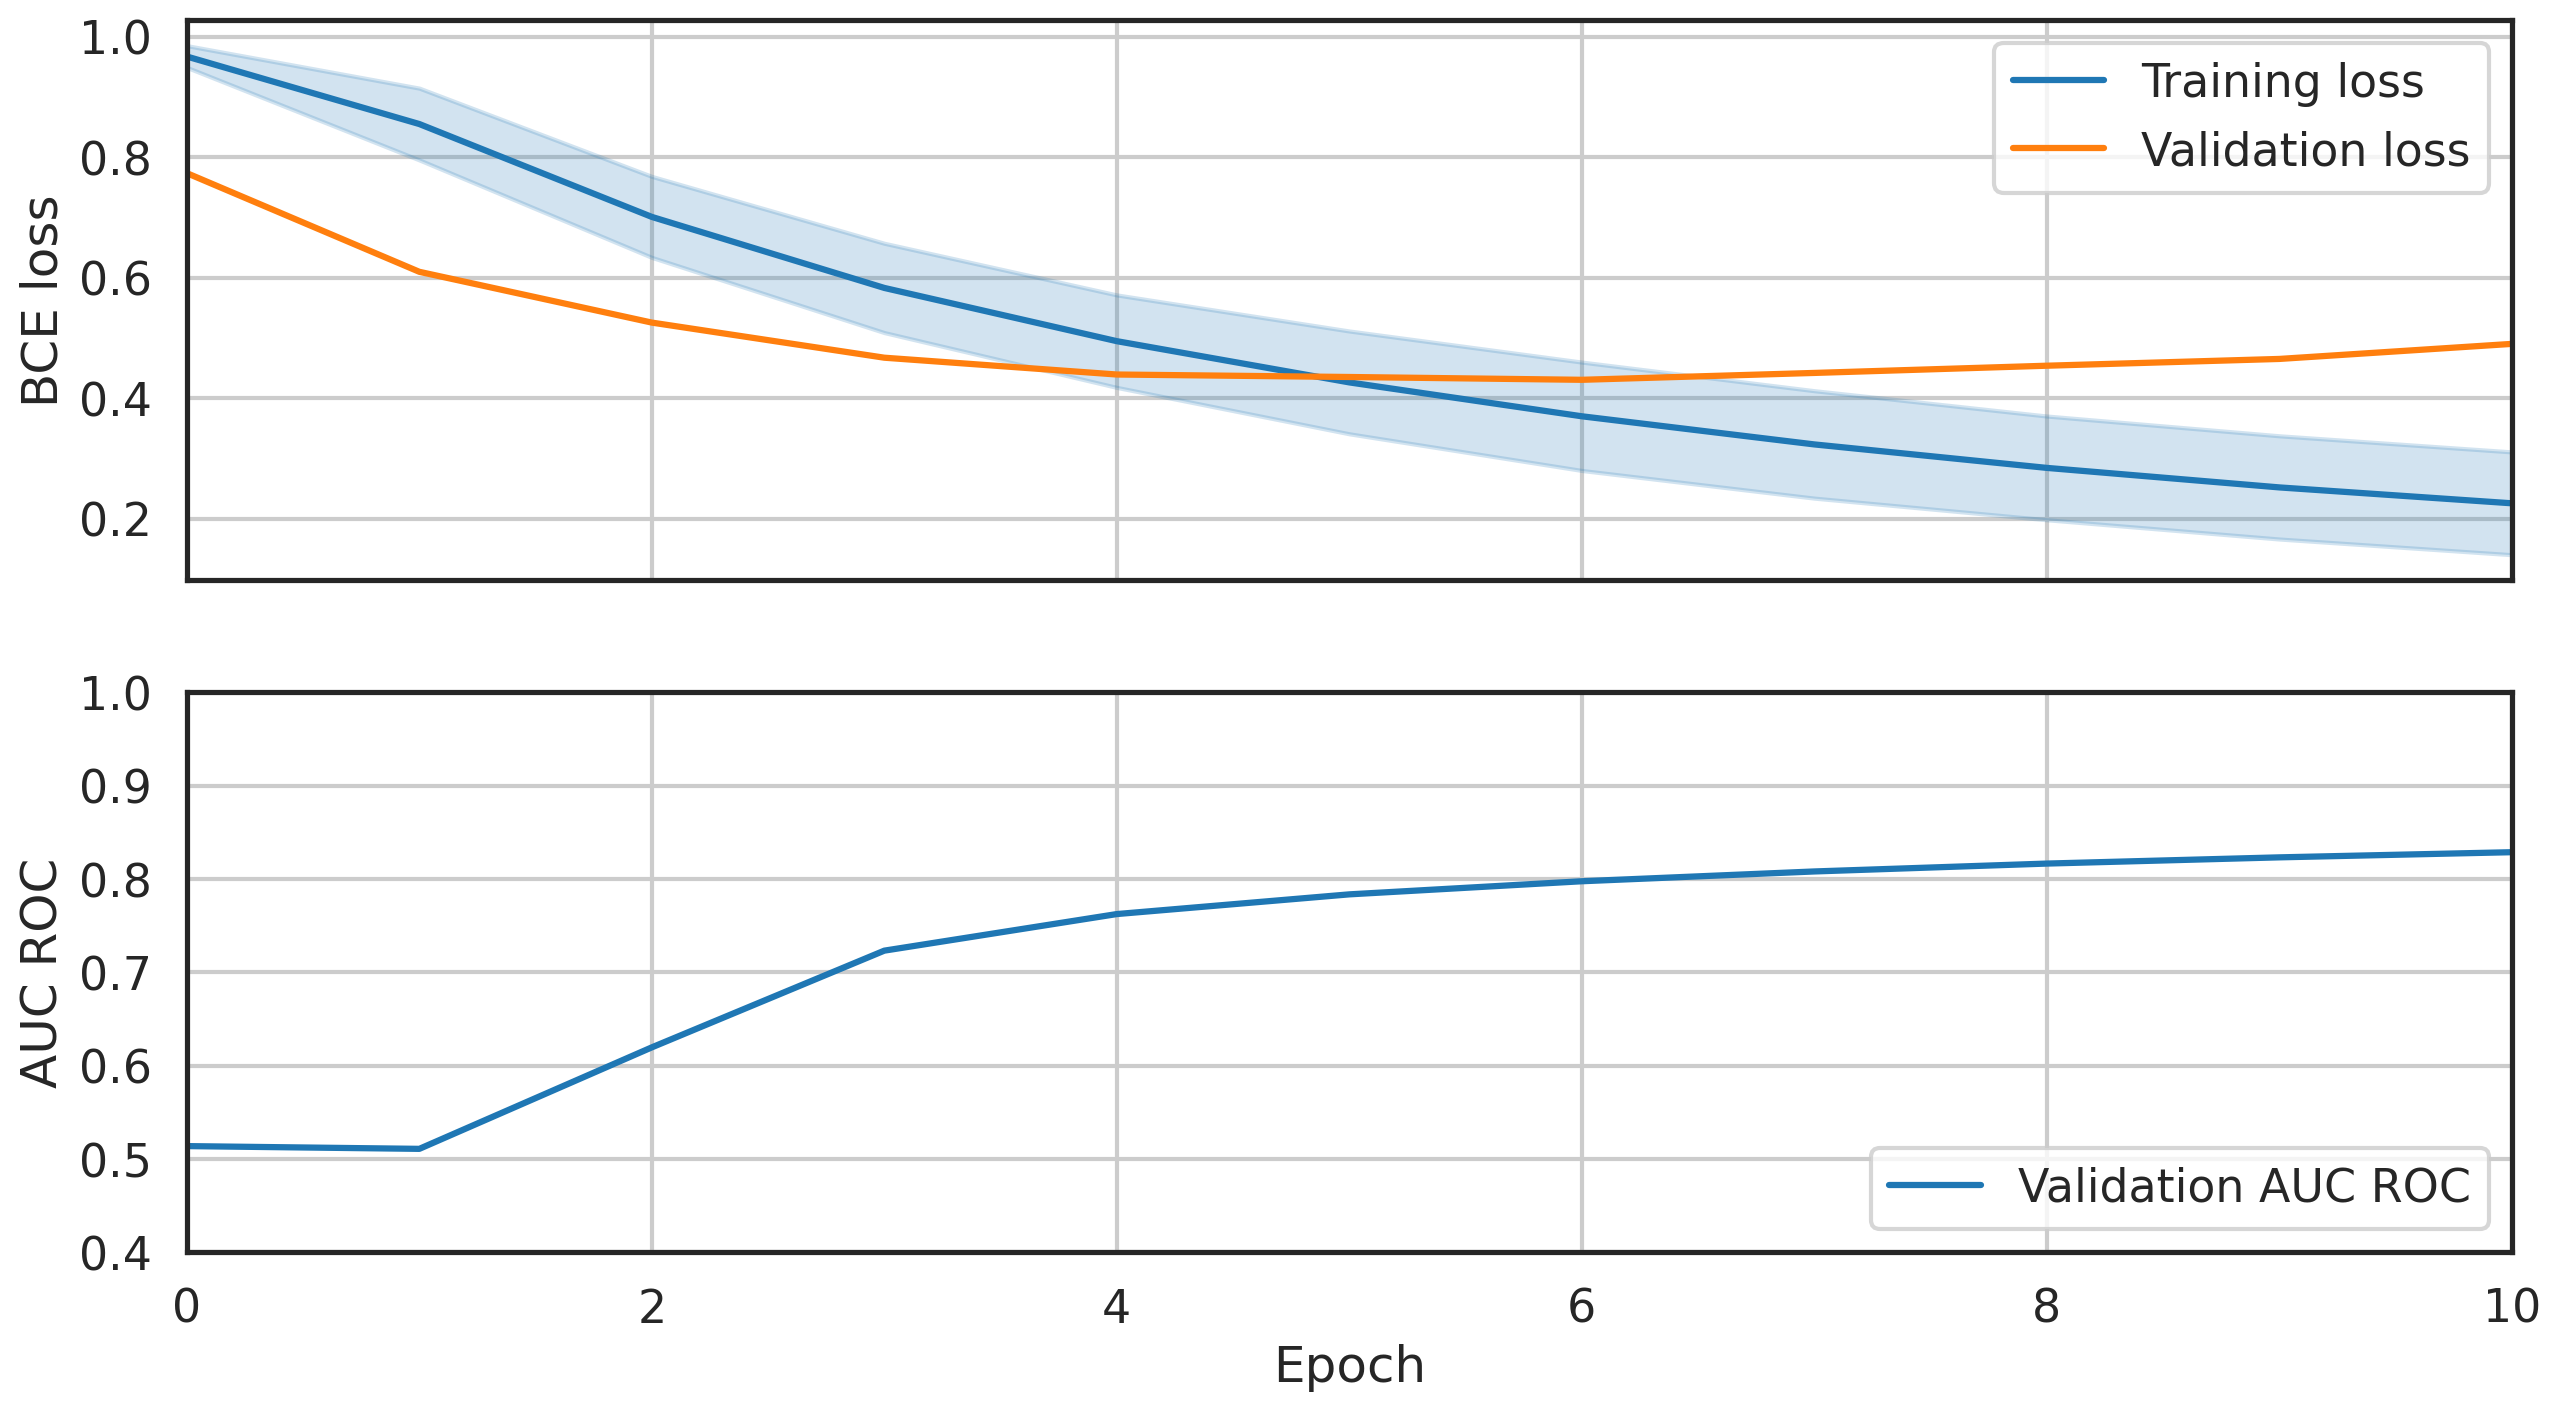

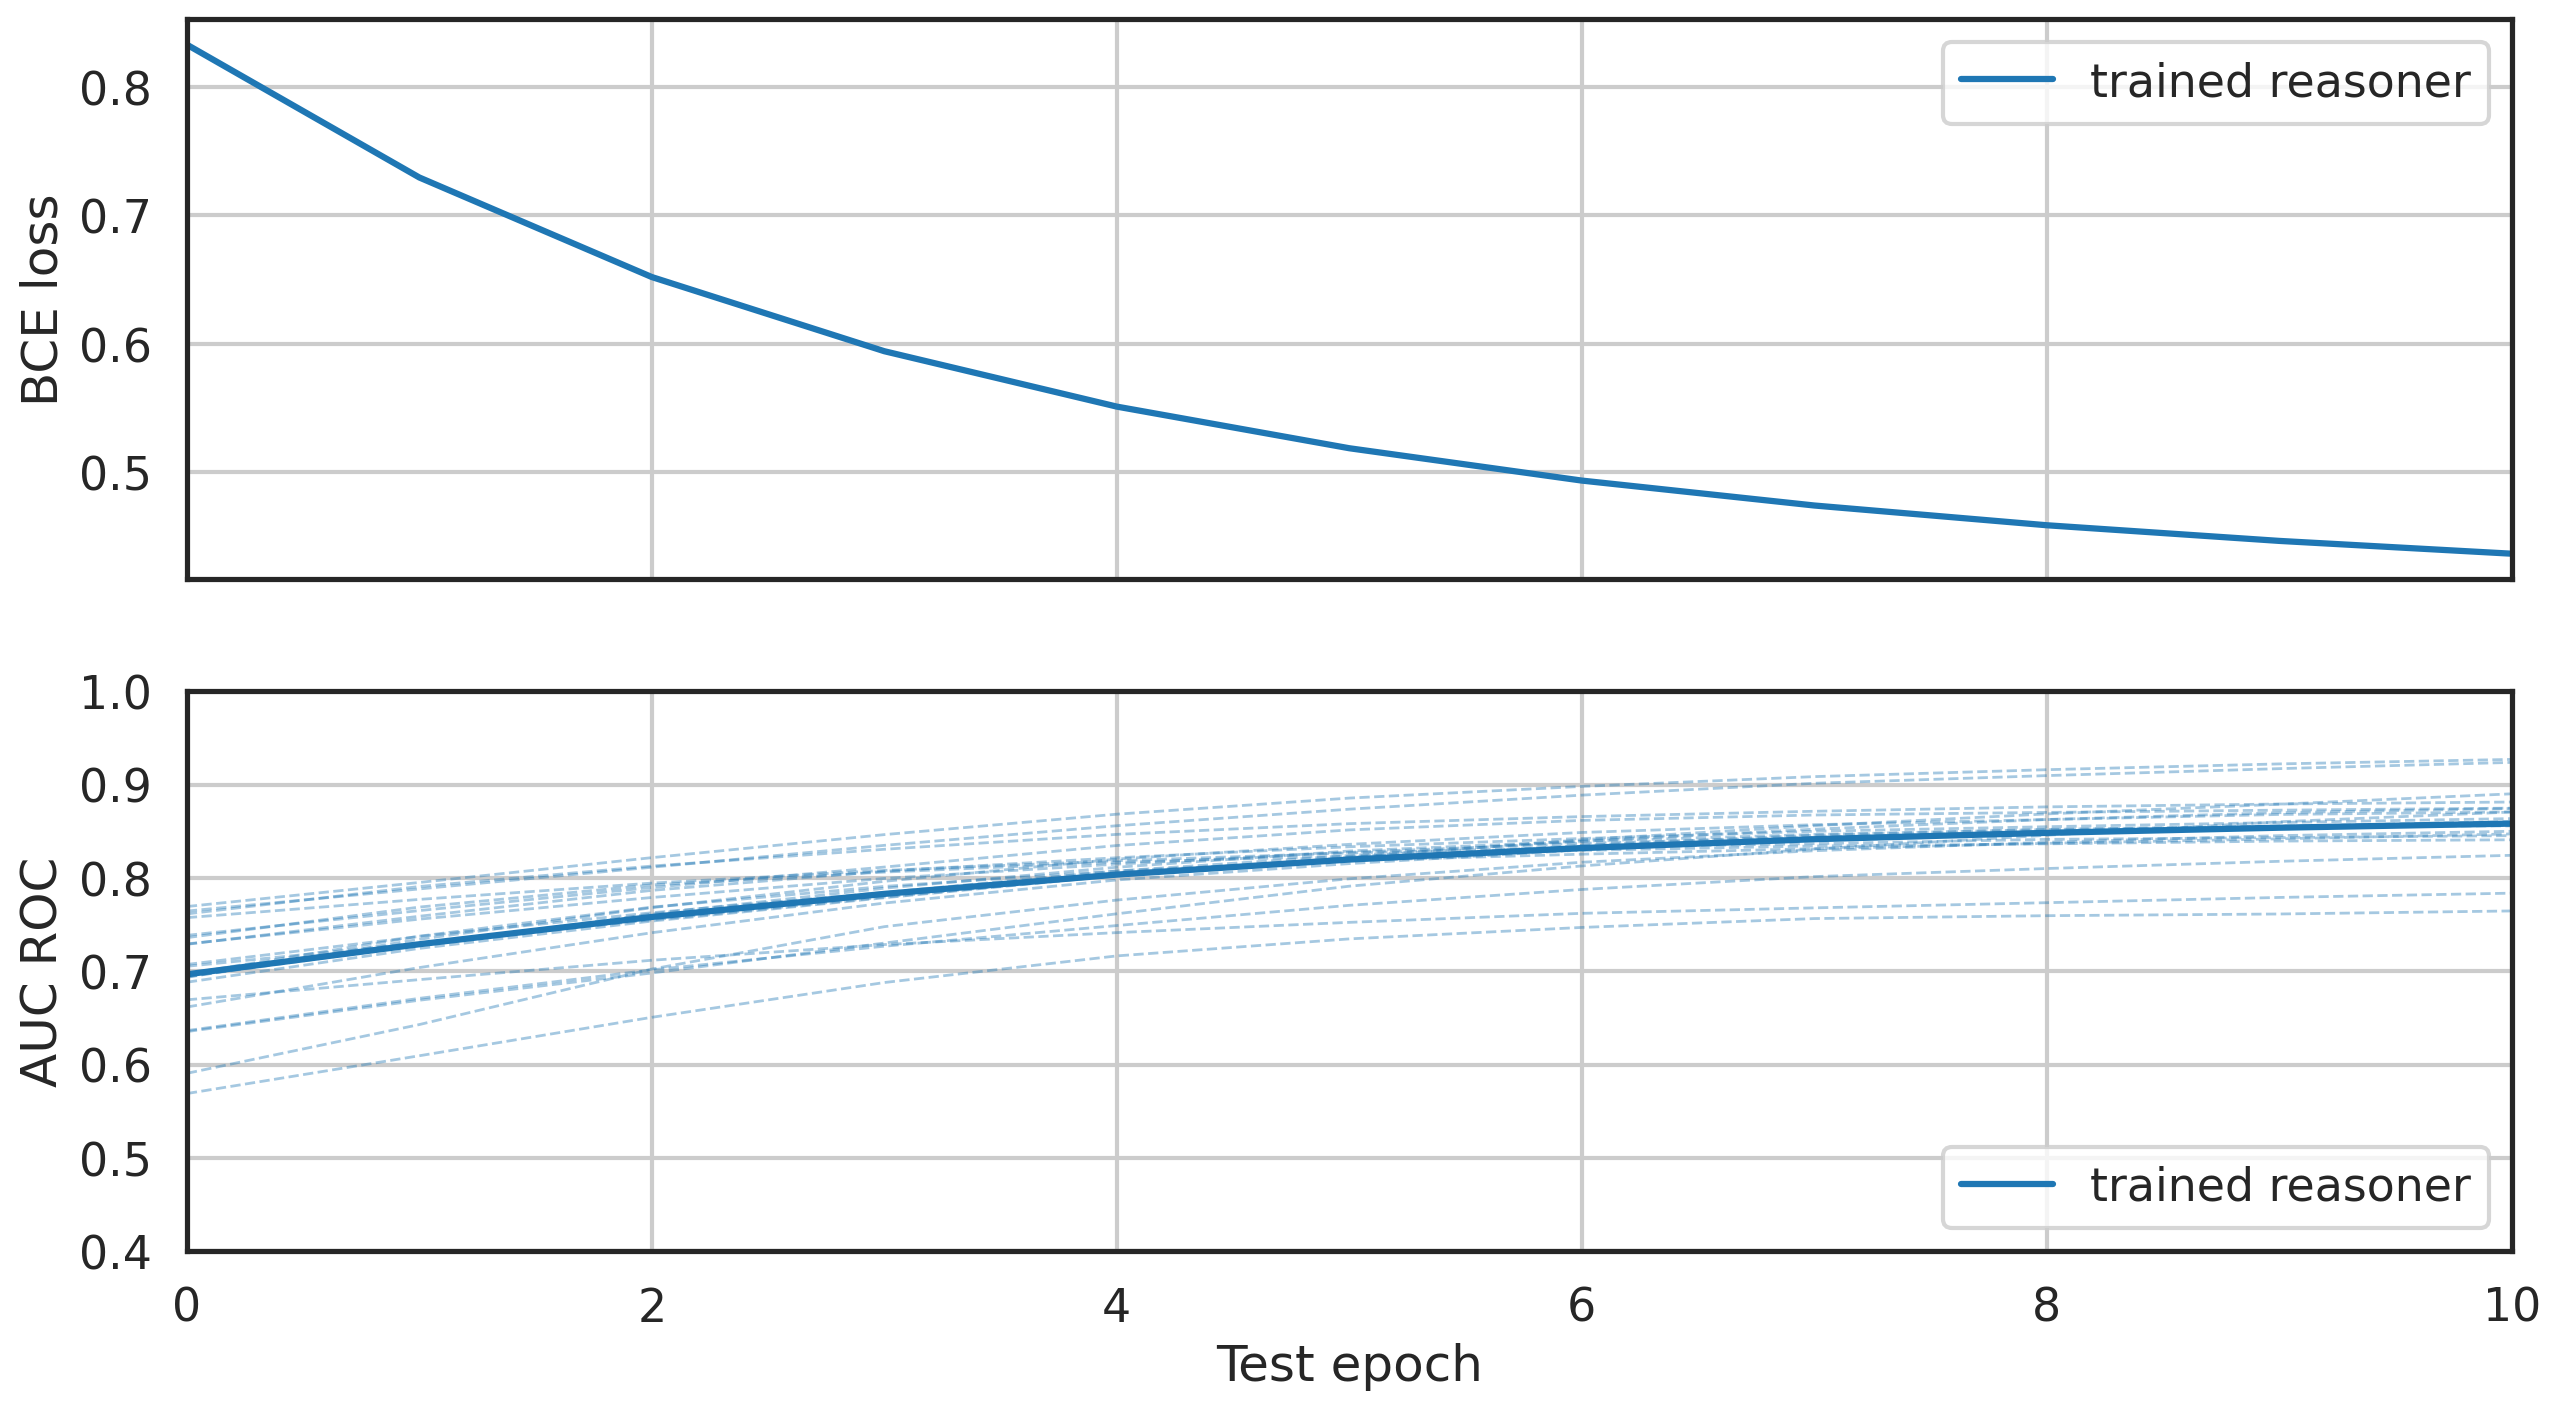

             mean       std     micro
acc      0.831632  0.041690  0.831844
prec     0.572839  0.100287  0.568047
recall   0.690994  0.085370  0.688845
f1       0.620556  0.075715  0.622642
auc_roc  0.847633  0.039179  0.847236
auc_pr   0.724034  0.077711  0.728078


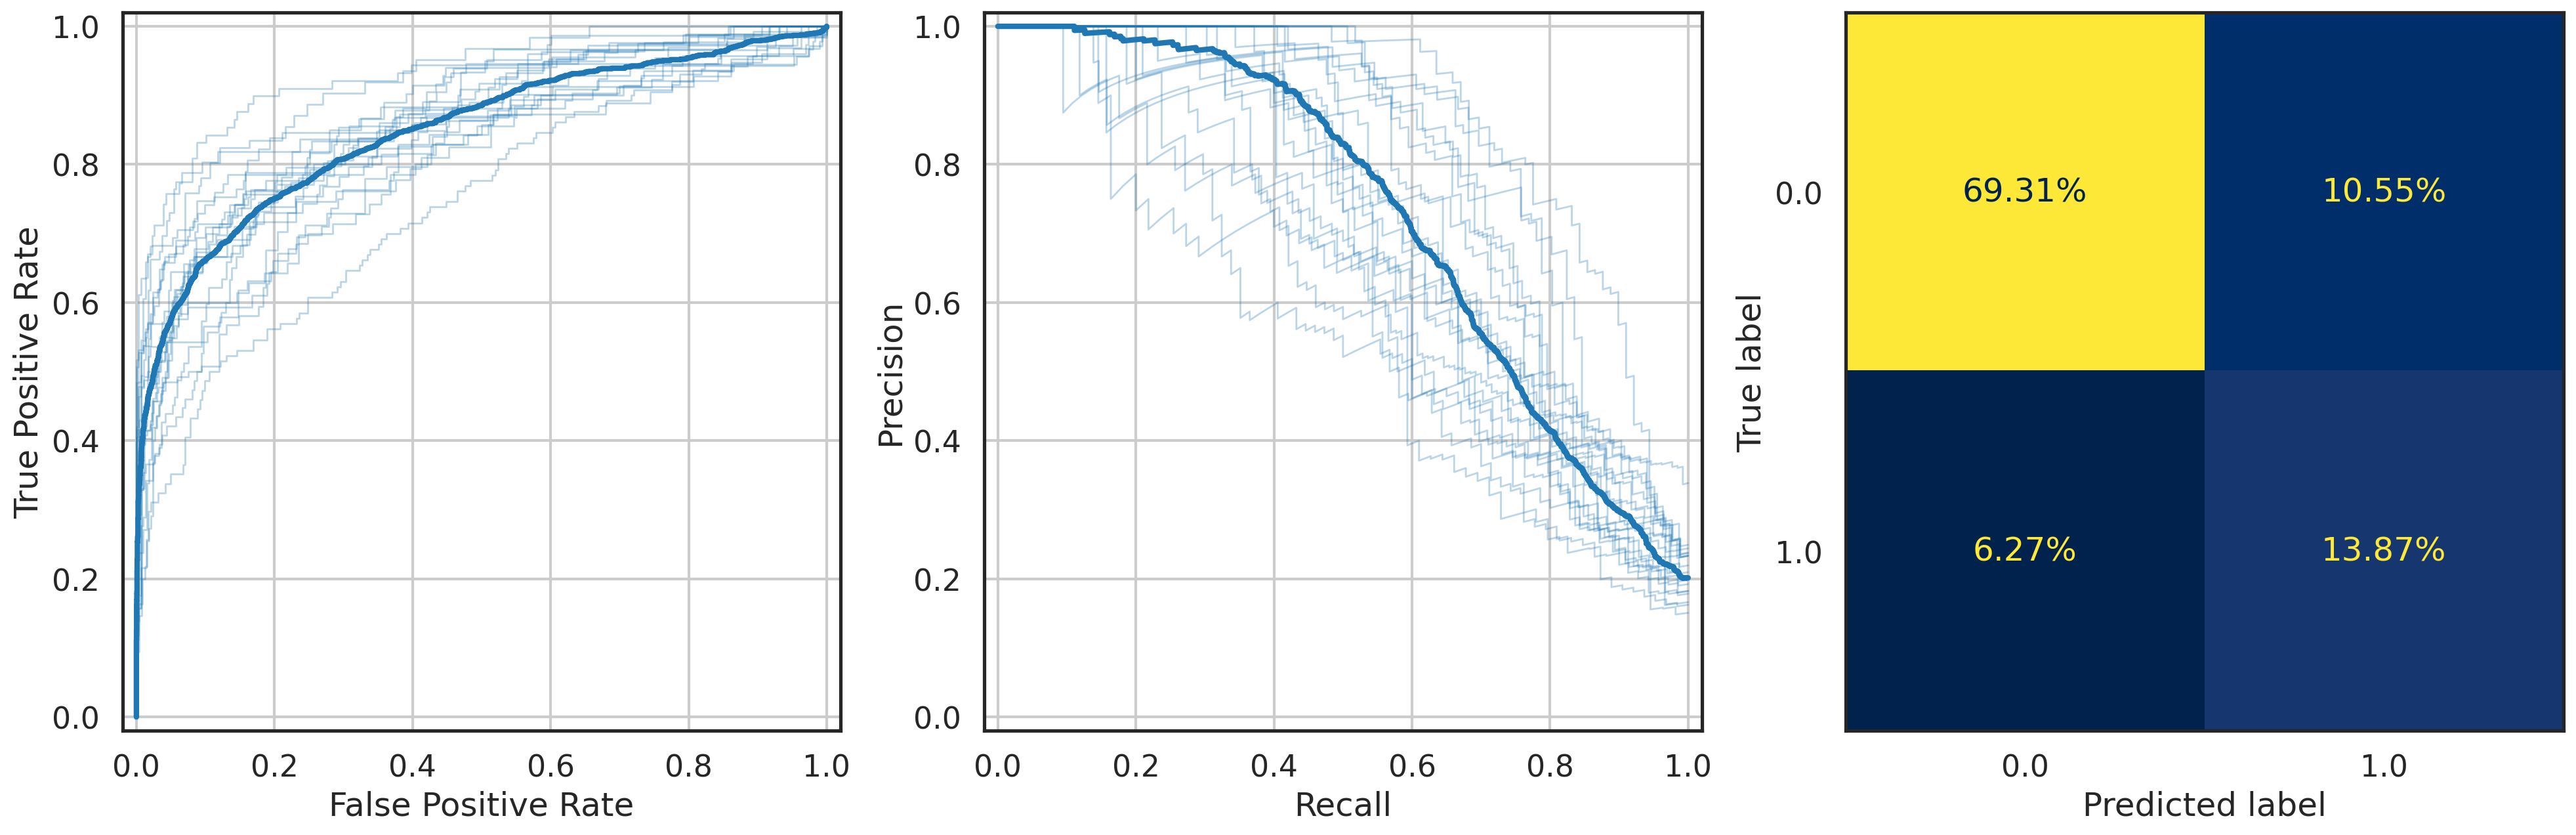

In [12]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te_te, y_te=y_te_te, Y_te_good=Y_te_good))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te_te, np.array(Y_te_good), idx_te_te))
# print(report(test_onto, y_te, np.array(Y_te_rand), idx_te))

In [13]:
import random

In [14]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im(input, input))).item() )


print(input)
print(trained_reasoner.and_nn(im( input, input)))
print(np.mean(losses))

tensor([ 0.0906, -0.1840,  0.3049,  0.2629,  0.2469,  0.1326, -0.0804,  0.2659,
        -0.0018,  0.1278], grad_fn=<SelectBackward0>)
tensor([ 0.2187,  0.0292,  0.2149, -0.1224,  0.2552, -0.1242, -0.0247,  0.0260,
        -0.1350, -0.0259], grad_fn=<AddBackward0>)
0.15644516088068486


In [15]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))

tensor([ 0.5812,  0.2825,  0.1574, -0.3576,  0.5896, -0.0400,  0.1411,  0.2341,
        -0.3912, -0.3005], grad_fn=<SelectBackward0>)
tensor([ 0.6519,  0.2800,  0.0927, -0.3351,  0.5490, -0.0049,  0.1594,  0.2528,
        -0.4149, -0.3090], grad_fn=<AddBackward0>)
0.04932941235601902


In [16]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))

tensor([ 0.1363, -0.0760, -0.1070, -0.0619, -0.1147,  0.0426, -0.0986,  0.1657,
         0.0351, -0.0801], grad_fn=<SelectBackward0>)
tensor([ 0.0361, -0.0735,  0.0456, -0.0721,  0.0202, -0.0293, -0.0457,  0.0058,
         0.0164,  0.0216], grad_fn=<AddBackward0>)
0.09080013111233712


In [17]:
losses = []
for _ in range(20):

    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([ 0.5812,  0.2825,  0.1574, -0.3576,  0.5896, -0.0400,  0.1411,  0.2341,
        -0.3912, -0.3005], grad_fn=<SelectBackward0>)
tensor([ 0.2624,  0.0522,  0.1963, -0.2120,  0.2553, -0.0992, -0.0026,  0.0490,
        -0.1494, -0.0695], grad_fn=<AddBackward0>)
0.2429661527276039


In [18]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.5812,  0.2825,  0.1574, -0.3576,  0.5896, -0.0400,  0.1411,  0.2341,
        -0.3912, -0.3005], grad_fn=<SelectBackward0>)
tensor([ 0.6756,  0.2824,  0.1302, -0.3573,  0.6430, -0.0398,  0.1443,  0.2494,
        -0.4324, -0.3005], grad_fn=<SqueezeBackward3>)
tensor(0.0235, grad_fn=<L1LossBackward0>)


In [19]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([-0.0566, -0.5013, -0.0623,  0.6072,  0.1265,  0.5623,  1.4278,  0.0074,
        -0.3371,  0.5405], grad_fn=<SelectBackward0>)
tensor([-0.0567, -0.4884, -0.0624,  0.5826,  0.1264,  0.5586,  1.2901,  0.0074,
        -0.3374,  0.4988], grad_fn=<SqueezeBackward3>)
tensor(0.0221, grad_fn=<L1LossBackward0>)


In [20]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))), trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))))
print(trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3)))
print(np.mean(losses))

tensor([ 0.4333,  0.1640,  0.0995, -0.2782,  0.3988, -0.0124,  0.0645,  0.1543,
        -0.3027, -0.1868], grad_fn=<AddBackward0>)
tensor([ 0.3894,  0.1898,  0.1459, -0.3157,  0.4432, -0.0837,  0.0864,  0.1302,
        -0.2767, -0.1560], grad_fn=<AddBackward0>)
0.023377026710659266


In [21]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im(input1, input2)), trained_reasoner.and_nn(im(input2, input1))).item())

print(trained_reasoner.and_nn(im(input1, input2)))
print(trained_reasoner.and_nn(im(input2, input1)))

print(np.mean(losses))

tensor([ 0.3133,  0.0331,  0.0977, -0.2515,  0.2532, -0.0069,  0.0662,  0.0522,
        -0.1659, -0.0667], grad_fn=<AddBackward0>)
tensor([ 0.2595,  0.0612,  0.1409, -0.2112,  0.2801, -0.1029, -0.0148,  0.0564,
        -0.1501, -0.0917], grad_fn=<AddBackward0>)
0.0295055097900331


In [22]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([ 0.0223,  0.1479, -0.2123, -0.1917,  0.1611,  0.2411, -0.1566,  0.1652,
         0.1375,  0.1187], grad_fn=<SelectBackward0>)
tensor([ 0.0280, -0.0087, -0.0098, -0.0623,  0.0008, -0.0271, -0.1054,  0.0305,
         0.0344,  0.0275], grad_fn=<AddBackward0>)
0.08761369101703168


In [23]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.9958304524421692


In [24]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.999975323677063
